# Board of Estimates Tabulator  
The purpose of this software tool is to use the pdf files that store the minutes of Baltimore's Board of Estimates to create a small database with linked tables for entities that could possibly include:

- meetings 
- agreements
- contracts
- contractors 
- personnel
- reclassifications

## Setup
### Import packages

In [28]:
from datetime import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from pathlib import Path
import time 
import seaborn as sns
import numpy as np

from utils import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

### Try out a key bit of syntax  
Since we will need to transform months into numbers, this bit of syntax is good to bear in mind.

In [2]:
time.strptime("November", "%B").tm_mon

11

### Define directories and urls
We'll also create the `pdf_files` directory if it doesn't exist already.

In [3]:
base_url = "https://comptroller.baltimorecity.gov/"
minutes_url = base_url + "boe/meetings/minutes"

root = Path.cwd()
pdf_dir = root / "pdf_files"

try:
    pdf_dir.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print("The pdf directory already exists.")
else:
    print("The pdf directory has been created.")

The pdf directory already exists.


### Store PDFs to local directory  
The following code downloads all the .pdf files with minutes from the Board of Estimates and saves them in your local version of this repository. 

The code will skip this time-consuming step if it detects files within the `pdf_files` directory.

The tricky part of this is getting a correct date for every file. Some files have a typo somewhere in html, so the functions `store_boe_pdfs()` and  `parse_long_dates()` are built to handle these errors. We may see new types of errors appear in the future, however.

In [4]:
if is_empty(pdf_dir):
    store_boe_pdfs(base_url, minutes_url)
else: 
    print("Files already exist in the pdf directory.")

Files already exist in the pdf directory.


## Process and prepare data
### Create a Pandas dataframe with full texts  
Now that we have the .pdf files we need, we're ready to read them and store their text in a Pandas dataframe. 

This should take about one minute for each year of data.

In [5]:
text_df_raw = store_pdf_text_to_df(pdf_dir)

Wrote 511 rows to the table of minutes.


### View a sample of the stored text

In [6]:
text_df_raw.sample(6, random_state=444)

,date,page_number,minutes
207,2009-06-24,2293,2293 BOARD OF ESTIMATES ...
215,2009-10-07,3766,"3766 BOARD OF ESTIMATES October 07, 2009 MIN..."
164,2012-07-11,2634,2634 BOARD OF ESTIMATES ...
158,2012-05-16,1777,1777 BOARD OF ESTIMATES ...
452,2011-08-17,2654,2654 BOARD OF ESTIMATES ...
451,2011-11-09,3705,3705 BOARD OF ESTIMATES ...


### Replace erroneous characters and consolidate white spaces
Not sure if decision to transform all multiple white spaces to a single white space will work for the long term because we may need to use multiple spaces to detect certain fields.

I hope we won't need to do that, though. Currently we're consolidating all multiple white spaces into just one white space.

In [7]:
text_df = text_df_raw.copy()

def replace_chars(val):
    val = ' '.join(val.split())
    val = val.replace('™', "'")
    val = val.replace('Œ', "-")
    return val

text_df['text'] = text_df['minutes'].apply(replace_chars)

In [9]:
# view a sample of the transformed text
print(text_df['text'][0][0:500])

4680 BOARD OF ESITMATES November 20, 2013 MINUTES REGULAR MEETING Honorable Bernard C. ﬁJackﬂ Young, President Honorable Stephanie Rawlings-Blake, Mayor - ABSENT Harry Black, Director of Finance Honorable Joan M. Pratt, Comptroller and Secretary George A. Nilson, City Solicitor Alfred H. Foxx, Director of Public Works David E. Ralph, Deputy City Solicitor Rudolph S. Chow, Deputy Director of Public Works Bernice H. Taylor, Deputy Comptroller and Clerk Pursuant to Article VI, Section 1(c) of the r


### Store the date of meeting as the index

In [10]:
text_df['date'] = pd.to_datetime(text_df['date'])
text_df = text_df.set_index('date', drop=False)
text_df['word_count'] = text_df['text'].apply(lambda x: len(x.split()))

text_df.head(3)

,date,page_number,minutes,text,word_count
date,,,,,
2013-11-20,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU...",22448
2013-01-30,2013-01-30,280,"280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUT...","280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUTE...",11455
2013-08-14,2013-08-14,3045,"3045 BOARD OF ESTIMATES August 14, 2013 MINUT...","3045 BOARD OF ESTIMATES August 14, 2013 MINUTE...",42186


## Compute and visualize a few basic features
Let's see how two very basic features change over time:

- Meetings per year
- Total word count of all meetings per year

In [12]:
meetings_per_year = text_df['minutes'].groupby(pd.Grouper(freq="Y")).count().reset_index()
meetings_per_year = meetings_per_year[meetings_per_year['date'] < '2020']
meetings_per_year.head(3)

,date,minutes
0,2009-12-31,44
1,2010-12-31,44
2,2011-12-31,46


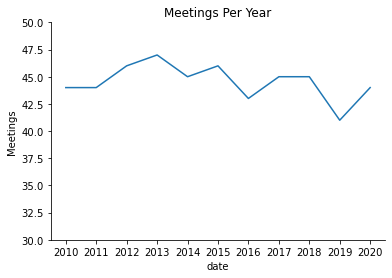

In [15]:
ax = sns.lineplot(x='date', y='minutes', data=meetings_per_year)

ax.set(title="Meetings Per Year", ylabel="Meetings", ylim=(30, 50))

sns.despine()

In [17]:
words_per_year = text_df.groupby(pd.Grouper(freq="Y"))['word_count'].sum().reset_index()
words_per_year = words_per_year[words_per_year['date'] < '2020']
words_per_year.head(3)

,date,word_count
0,2009-12-31,777035
1,2010-12-31,763262
2,2011-12-31,814751


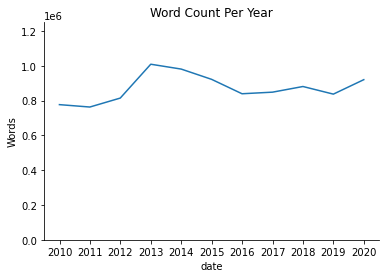

In [18]:
ax = sns.lineplot(x='date', y='word_count', data=words_per_year)

ax.set(title="Word Count Per Year", ylabel="Words", ylim=(0, 1_250_000))

sns.despine()

## Tabulate data
### Create empty dataframes

In [19]:
def create_dateframes():
    meetings_df = pd.DataFrame(
        columns=["date", "president", "mayor", "no_of_protests", "no_of_settlements",]
    )
    agreements_df = pd.DataFrame(
        columns=["date", "department", "contractor", "account_number", "agreement",]
    )
    accounts_df = pd.DataFrame(
        columns=["date", "account_number",]
    )
    
    return meetings_df, agreements_df, accounts_df

agreements_df, meetings_df, accounts_df = create_dateframes()

### Test out account regex

In [20]:
account_lookup = r"\d{4}-\d{6}-\d{4}-\d{6}-\d{6}"
sample_text = text_df['text'][-7]
sample_text = '5000-585919-1191-719000-603096'
list_of_accounts = list(re.findall(re.compile(account_lookup), sample_text))
len(list_of_accounts)

1

### List all account numbers for each meeting

In [27]:
def find_all_accounts(row):
    account_lookup = r"\d{4}-\d{6}-\d{4}-\d{6}-\d{6}"
    meeting_date = row['date']
    list_of_accounts = list(re.findall(re.compile(account_lookup), row['text']))
    return list_of_accounts
    

text_df['accounts'] = text_df.apply(find_all_accounts, axis=1)
text_df.head()

,date,page_number,minutes,text,word_count,accounts
date,,,,,,
2013-11-20,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU...",22448,"[4000-496313-3573-591219-603051, 2089-208914-5..."
2013-01-30,2013-01-30,280,"280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUT...","280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUTE...",11455,"[9905-922004-9188-900000-709047, 4000-807513-6..."
2013-08-14,2013-08-14,3045,"3045 BOARD OF ESTIMATES August 14, 2013 MINUT...","3045 BOARD OF ESTIMATES August 14, 2013 MINUTE...",42186,"[2032-000000-1330-158400-605008, 2044-000000-1..."
2013-08-28,2013-08-28,3346,"3346 BOARD OF ESTIMATES AUGUST 28, 2013 MINUT...","3346 BOARD OF ESTIMATES AUGUST 28, 2013 MINUTE...",25506,"[5000-598014-2252-688000-600000, 5000-598314-2..."
2013-06-05,2013-06-05,2018,"2018 BOARD OF ESTIMATES JUNE 05, 2013 MINUTES...","2018 BOARD OF ESTIMATES JUNE 05, 2013 MINUTES ...",22474,"[2036-000000-1752-175200-603070, 1001-000000-1..."


### Unnest account numbers
This takes all the account numbers that were stored together in a list and makes each one its own row.

In [22]:
def unnesting(df, explode):
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat([
        pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1)
    df1.index = idx
    return df1.join(df.drop(explode, 1), how='left')

        
accounts_df = unnesting(text_df,['accounts'])

### Count the account numbers mentioned per year
Not sure if this is the right approach to dropping duplicate account numbers, but for now I'm dropping anything where the same account is mentioned in the same meeting.

In [23]:
#accounts_df = accounts_df.drop_duplicates(subset=['date', 'accounts'], keep='last')
accounts_df = accounts_df.drop_duplicates(subset=['date', 'accounts'], keep='last')
accounts_per_year = accounts_df.groupby(pd.Grouper(freq="Y"))['accounts'].count().reset_index()

accounts_per_year.head()

,date,accounts
0,2009-12-31,1532
1,2010-12-31,2022
2,2011-12-31,1813
3,2012-12-31,1945
4,2013-12-31,1974


### Hmm. That's weird.
Looks like accounts dropped off quickly in 2015.

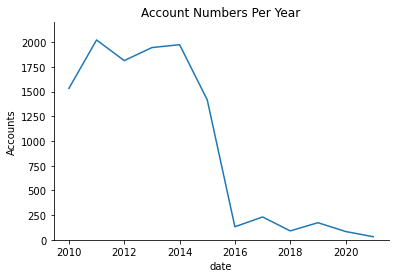

In [30]:
ax = sns.lineplot(x='date', y='accounts', data=accounts_per_year)

ax.set(title="Account Numbers Per Year", ylabel="Accounts", ylim=(0, 2200))

sns.despine()

In [ ]:
#^.+?(?=(\s–|-\s).*Agreements)
# department_lookup = r"^.+?(?=–|-.*Agreements)"
# department_lookup = r"(?<=MINUTES).+?(?=(\s–|-\s).*)"
# department_lookup = r"(?<=MINUTES).+(?=(\s-\s))"